# Realized images with GAN
## In this notebook I attempt to recreate images using BIGGAN

We have had limited success with straight image recreation. Time to get creative. What we are going to try to attempt here is to use GANs to generate the image which most closely resembles the image that was truly being looked at. This will take two steps. First, we need a neural net which can generate embeddings out of an image which are similar to the brain embeddings. Then we need a GAN which can generate images which we will feed into our encoder. We are going to try to search for the image which most closely a similar brainstate to the true one. 

Before we do all of this, we first need to import our GAN, set parameters, and see if we can get it to do some image recreation. 

First importing our GAN

In [1]:
# IMPORTS
import torch
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample)
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision import models
from torchvision import transforms
from tqdm import tqdm
import cv2
# for reproducibility
torch.manual_seed(0)

In [2]:
# To show our ims helper
def show_images(im_batch):
    ims = np.transpose(im_batch.detach().numpy(), (0, 2, 3, 1))
    ims = (ims - np.min(ims)) / (np.max(ims) - np.min(ims))
    R = int(len(ims[0])/2+1)
    C = 2
    plt.figure(figsize=(4, 200))
    for i in range(len(ims)):
        plt.subplot(R, C, i+1)
        plt.axis('off')
        plt.imshow(ims[i], interpolation='bilinear')
    plt.show()

Showing a sample generated img.

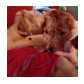

In [5]:
# Load pre-trained model tokenizer (vocabulary)
bGAN = BigGAN.from_pretrained('biggan-deep-256')
# Freezing params in our GAN
for param in bGAN.parameters():
    param.requires_grad = False
# 1 is no truncation
truncation = 1
# index = 8 # to get a chicken
class_vector = np.zeros((1, 1000))
# class_vector[0][index] = 1
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=1)

# All in tensors
noise_vector = torch.from_numpy(noise_vector).float()
class_vector = torch.from_numpy(class_vector).float()

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
bGAN.to('cuda')

# Generate an image
with torch.no_grad():
    output = bGAN(z=noise_vector, class_label=class_vector, truncation=truncation)

# Put back on CPU
output = output.to('cpu')
np.save("./data/GAN_ims/myImg.npy", output) # Our preferred chicken has already been selected
show_images(output)

Lets try to recreate this img ^ by searching through the input noise. 

In [6]:
# here is our model
class searchGAN(nn.Module):
    def __init__(self, GAN):
        super().__init__()
        
        # 7 linear units in a row seems to do quite learning in searching
        self.searcher = nn.ModuleList()
        for i in range(7):
            self.searcher.extend([
                    nn.Linear(128, 128), 
                    nn.ELU(),
            ])
        self.searcher = nn.Sequential(*self.searcher)
        self.pre_trained_GAN = GAN
    
    def forward(self, x, label, trunc):
        x = self.searcher(x)
        # Here is our static pretrained GAN
        x = self.pre_trained_GAN(x, label, trunc)
        return x

Here is our model. It essentially just needs to search for a suitable input. Interestingly, having more layers seems to help. 7 seems to be a good number of layers to be involved in the search. 

Our search loop. Loading in the target and then trying to match

loss: tensor(0.3101, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0954, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0757, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0687, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0764, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0680, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0626, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0685, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0586, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0552, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0558, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0516, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0523, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0507, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0505, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0493, devi

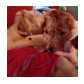

recreated image


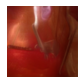

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_epochs = 500

# Reloading the model 
generator = searchGAN(bGAN).to(device)
optimizerG = torch.optim.Adam(generator.parameters(), lr = 3e-3)
criterion = nn.MSELoss()

index = 8 # np.random.randint(0, 1000) setting to chicken for now
class_vector = torch.zeros((1, 1000)).to(device)

# setting our input to all 1s intially
latent = torch.ones((1, 128)).to(device)
target = torch.from_numpy(np.load("./data/GAN_ims/myImg.npy")).to(device)
truncation = 1

# Train
for epoch in range(n_epochs):
    generator.zero_grad()
    ims_gen = generator(latent, class_vector, truncation) # Generate an img using the current input
    loss = criterion(ims_gen, target) 
    loss.backward() # Backprop the difference 
    optimizerG.step() # Step and repeat
    if epoch%20 == 0:
        print("loss:", loss)
    
print("original image")
show_images(target.to('cpu'))
print("recreated image")
show_images(ims_gen.to('cpu'))

A decent replication. We could traing for a bit longer and potentially perfectly replicate. This should be possible given that this GAN generated this img in the first place. However, it is foreseeable that the level of precision needed to find the perfect initial conditions is high and so we will always be off by a bit. Further, in GANS, it is often the case that small changes in the input dimension result in large changes in the output. 

Let try this again except with an unseen image of a chicken. 

loss: tensor(0.5138, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0275, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0252, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward>)
original image


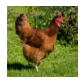

recreated image


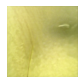

In [11]:
n_epochs = 200
generator = searchGAN(bGAN).to('cuda') # Resetting the model 
optimizerG = torch.optim.Adam(generator.parameters(), lr = 3e-3)
criterion = nn.MSELoss()

index = 8 # np.random.randint(0, 1000)
class_vector = torch.zeros((1, 1000)).to('cuda')
class_vector[0][index] = 1

latent = torch.ones((1, 128)).to('cuda')

# Getting our target chicken -> in real_chicken.jpeg
target = Image.open("data/GAN_ims/real/real_chicken.jpeg")
target = np.array(target.resize((256, 256), Image.BICUBIC)).copy()
target = (torch.from_numpy(target.transpose(2, 0, 1)).unsqueeze(0)/256).to(device)
truncation = 1

for epoch in range(n_epochs):
    generator.zero_grad()
    ims_gen = generator(latent, class_vector, truncation)
    loss = criterion(ims_gen, target)
    loss.backward()
    optimizerG.step()
    if epoch%20 == 0:
        print("loss:", loss)
        
print("original image")
show_images(target.to('cpu'))
print("recreated image")
show_images(ims_gen.to('cpu'))

As can be seen, this is not a great image recreation. Our GAN has just made most things brown-greenish. This is a problem which may be inherent in our loss function MSE which gives no benefit to generating a chicken. It is doing loss pixel by pixel. 

Lets try using the last fully connected layer of mobilenet as our loss comparator. This should capture a wider range of features such as 'chicken'. 

A further potential issue is that some images might simply be out of the scope of what our GAN can generate. To fix this our only choice would be to train a bigger GAN on more data. 

First we define our image vectorizer and test that it works

In [8]:
class image2Vec(nn.Module):
    def __init__(self):
        super().__init__()
        # Here is mobile net
        self.model = models.mobilenet_v3_small(pretrained=True).to('cuda')
        self.featureLayer = self.model._modules.get('classifier')[3] # Corresponds to the second last layer of the network. 
        
        # Using tricks to copy the ouput of the second last layer
        self.featureLayer.register_forward_hook(self.hook)
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    def hook(self, m, i, o):
        self.embed = i
        
    def forward(self, x):
        if not x.is_cuda:
            x = x.to('cuda')
        x = self.normalize(x)
        self.model(x)

        return self.embed[0]

resNetVec = image2Vec() 
# Turning off gradients
for param in resNetVec.parameters():
    param.requires_grad = False
    
# Checking that it works
allVectors = {}
for image in tqdm(os.listdir("data/GAN_ims/real")):
    I = torch.Tensor(cv2.imread(os.path.join("data/GAN_ims/real", image)).transpose(2, 0, 1)).unsqueeze(0)/255
    vec = resNetVec(I)
    allVectors[image] = vec

100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


It appears to work. Now define the entire model. A note, I am somewhat uncertain about the quality of the embedding produced by this pretrained net. I found little documentation as to what the net has been pretrained to do. I assumed that it was a classifier, but the output of the net is not like a classifier. Regardless, lets see how it does:

In [10]:
# here is our model
class searchGAN2(nn.Module):
    def __init__(self, GAN, resNet):
        super().__init__()
        # 7 linear units in a row seems to do quite well in searching
        self.searcher = nn.ModuleList()
        for i in range(20):
            self.searcher.extend([
                    nn.Linear(128, 128), 
                    nn.ELU(),
            ])
        self.searcher = nn.Sequential(*self.searcher)
        self.pre_trained_GAN = GAN
        self.resNetVec = resNet
        self.transform = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
             std=[0.229, 0.224, 0.225]
        )
    
    def forward(self, x, label, trunc):
        x = self.searcher(x)
        # Here is our static pretrained GAN
        img = self.pre_trained_GAN(x, label, trunc)
        img = self.transform(img)
        embedding = self.resNetVec(img)
        return img, embedding
    

Running the recreation test. 

loss: tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0231, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward>)
original image


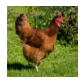

recreated image


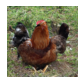

In [15]:
n_epochs = 500
resNetVec = image2Vec() 
# Turning off gradients
for param in resNetVec.parameters():
    param.requires_grad = False
    
# Load pre-trained model tokenizer (vocabulary)
bGAN = BigGAN.from_pretrained('biggan-deep-256')
# Freezing params in our GAN
for param in bGAN.parameters():
    param.requires_grad = False
    
generator = searchGAN2(bGAN, resNetVec).to('cuda') # Resetting the model 
optimizerG = torch.optim.Adam(generator.parameters(), lr = 3e-4)
# criterion = nn.MSELoss()
class_vector = torch.zeros((1, 1000)).to('cuda')
latent = torch.ones((1, 128)).to('cuda')
class_vector[0][8]=1
# Getting our target chicken -> in real_chicken.jpeg
target = Image.open("data/GAN_ims/real/real_chicken.jpeg")
target = np.array(target.resize((256, 256), Image.BICUBIC))
target = target.copy()
target = (torch.from_numpy(np.asarray(target).transpose(2, 0, 1)).unsqueeze(0)/256).to('cuda')
embed_real = resNetVec(target)
truncation = 1

for epoch in range(n_epochs):
    generator.zero_grad()
    img, embed_fake = generator(latent, class_vector, truncation)
    loss = criterion(embed_fake, embed_real)
    loss.backward()
    optimizerG.step()
    if epoch%50 == 0:
        print("loss:", loss)
        
print("original image")
show_images(target.to('cpu'))
print("recreated image")
show_images(img.to('cpu'))

Nice! Our model was able to figure out that we were looking for a chicken, and gave that to us. It isn't the chicken we want, but atleast its a chicken, and they share quite similar features. Lets try again using the generated image above. 

loss: tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(0.0041, devi

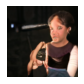

recreated image


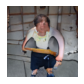

In [16]:
n_epochs = 1000
generator = searchGAN(bGAN, resNetVec).to('cuda') # Resetting the model 
optimizerG = torch.optim.Adam(generator.parameters(), lr = 3e-5)
criterion = nn.MSELoss()

index = 8 # np.random.randint(0, 1000)
class_vector = torch.zeros((1, 1000)).to('cuda')

latent = torch.ones((1, 128)).to('cuda')
# Getting our target chicken -> in real_chicken.jpeg
target = torch.from_numpy(np.load("./data/GAN_ims/myImg.npy")).to('cuda')
embed_real = resNetVec(target)
truncation = 1

for epoch in range(n_epochs):
    generator.zero_grad()
    img, embed_fake = generator(latent, class_vector, truncation)
    loss = criterion(embed_fake, embed_real)
    loss.backward()
    optimizerG.step()
    if epoch%50 == 0:
        print("loss:", loss)
        
print("original image")
show_images(target.to('cpu'))
print("recreated image")
show_images(img.to('cpu'))

This is interesting. The image is sort of abstract in a similar way to the one above it. 

Lets finish this notebook here. In the next notebook we use our GAN to reconstruct images. 